<a href="https://colab.research.google.com/github/TheGooseGuy/Insurance-Product-Prediction/blob/main/Data-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Stephen Torku, Zikang Ge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

pd.set_option('display.precision', 2)                     # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn-v0_8')                             # pretty matplotlib plots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Training.xlsx") # Read training data set
test = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Test.xlsx") # Read testing data set

In [4]:
train_data = train.copy()
test_data = test.copy()

# Data Pre-processing

In [5]:
# Rename test data columns to match train data
test_data.rename(columns={
    'ANNUALKM': 'ANNUAL_KM',
    'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
    'MARKINGSYSTEM': 'MARKING_SYSTEM',
    'TRACKINGSYSTEM': 'TRACKING_SYSTEM',
    'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP',
    'VEHICLEVALUE': 'VEHICLE_VALUE',
    'YEAROFBIRTH': 'YEAR_OF_BIRTH',
    'POSTALCODE': 'POSTAL_CODE',
    'AREACODE': 'AREA_CODE',
    'YEARSLICENSED': 'YEARS_LICENSED',
    'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER',
    'MULTIPRODUCT': 'MULTI_PRODUCT',
    'MARITALSTATUS': 'MARITAL_STATUS',
    'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS',
    'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS',
    'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS',
    'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS',
    'SUSPENSIONCOUNT': 'SUSPENSION_COUNT',}, inplace=True)

In [6]:
# Check for NA values in each column
for column in train_data.columns:
    if train_data[column].isna().sum() > 0:
        print(f"{column} has {train_data[column].isna().sum()} missing values.")
print("")
for column in test_data.columns:
    if test_data[column].isna().sum() > 0:
        print(f"{column} has {test_data[column].isna().sum()} missing values.")

ANNUAL_KM has 1 missing values.
COMMUTE_DISTANCE has 35413 missing values.
MARKING_SYSTEM has 101866 missing values.
TRACKING_SYSTEM has 101887 missing values.
VEHICLE_OWNERSHIP has 76450 missing values.
VEHICLE_VALUE has 64673 missing values.
GENDER has 5 missing values.
YEARS_LICENSED has 8 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 101279 missing values.
OCCUPATION has 1 missing values.

COMMUTE_DISTANCE has 5191 missing values.
MARKING_SYSTEM has 15095 missing values.
TRACKING_SYSTEM has 15112 missing values.
VEHICLE_OWNERSHIP has 11500 missing values.
VEHICLE_VALUE has 10159 missing values.
YEARS_LICENSED has 3 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 14946 missing values.


## Data Cleaning & Feature Engineering

In [7]:
# Vehicle_makes
distinct_vehicle_makes = train_data['VEHICLEMODEL'].unique()
print(distinct_vehicle_makes)

print("")

distinct_vehicle_makes = test_data['VEHICLEMAKE'].unique()
print(distinct_vehicle_makes)

['JETTA 2.5 4P' 'ELANTRA GL 4DR' 'SILVERADO 2500 HD LT CREW CAB 4WD' ...
 'SILVERADO 1500 LS DOUBLE CAB 2WD' '500 SPORT 2P' '2.3CL 2DR']

['HONDA' 'FORD TRUCK/VAN' 'DODGE/RAM TRUCK/VAN' 'FORD'
 'CHEVROLET TRUCK/VAN' 'GMC TRUCK/VAN' 'BMW TRUCK/VAN' 'ACURA' 'TOYOTA'
 'TOYOTA TRUCK/VAN' 'CHRYSLER' 'KIA' 'MAZDA TRUCK/VAN' 'CHEVROLET' 'MAZDA'
 'NISSAN TRUCK/VAN' 'MITSUBISHI' 'HYUNDAI TRUCK/VAN' 'PONTIAC'
 'KIA TRUCK/VAN' 'NISSAN' 'LEXUS TRUCK/VAN' 'MERCEDES-BENZ TRUCK'
 'VOLKSWAGEN TRUCK/VAN' 'BUICK' 'VOLKSWAGEN' 'VOLVO' 'MERCEDES-BENZ'
 'HONDA TRUCK/VAN' 'HYUNDAI' 'BMW' 'INFINITI TRUCK/VAN'
 'CADILLAC TRUCK/VAN' 'JEEP' 'HYUNDAI CAMION/VAN' 'MITSUBISHI TRUCK/VAN'
 'BUICK TRUCK/VAN' 'SUBARU' 'FORD CAMION/VAN' 'MERZ' 'LINCOLN TRUCK/VAN'
 'CHRYSLER TRUCK/VAN' 'DODGE' 'PONTIAC TRUCK/VAN' 'LEXUS' 'MERCURY'
 'SATURN TRUCK/VAN' 'OLDSMOBILE' 'AUDI' 'PORSCHE TRUCK/VAN' 'MASERATI'
 'CADILLAC' 'VOLVO TRUCK/VAN' 'AUDI TRUCK/VAN' 'MINI' 'LAND ROVER'
 'ACURA TRUCK/VAN' 'LEXUS CAMION/VAN' 'INFINITI' 'FIAT

In [8]:
# Combine train data and test data, will split them in the end
train_data['is_train'] = 1
test_data['is_train'] = 0

combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [9]:
# QUOTEDATE
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
combined_data['VEHICLE_AGE'] = pd.to_datetime(combined_data['QUOTEDATE']).dt.year - combined_data['VEHICLEYEAR']
combined_data['Season'] = combined_data['QUOTEDATE'].apply(get_season)

# Encode 'Season' using pd.get_dummies
combined_data = pd.get_dummies(combined_data, columns=['Season'], prefix='Season')

# Drop 'Quote_Month' if you no longer need it
combined_data = combined_data.drop(columns=['QUOTEDATE'])

In [10]:
# VEHICLEYEAR

# Group by vehicle age brackets
def vehicle_age_group(year):
    if year < 2000:
        return 'Vintage'
    elif year < 2010:
        return 'Old'
    else:
        return 'Modern'

combined_data['Vehicle_Age_Group'] = combined_data['VEHICLEYEAR'].apply(vehicle_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Age_Group'], prefix='Age')

In [11]:
# Define your regex replacements dictionary
replacements = {
  # Volkswagen variations
  r'\bVW\b|\bWV\b|\bVOLKS\b|VOLKSWAGON|VOLGSWAGEN|VOLSWAGEN|VOLKSWAGENJAVASCRIPT:VOID\(0\)|VOLLKS|VOLKSWAGEN(?:\s+TRUCK/VAN|\s+CAMION/VA)?': 'VOLKSWAGEN',

  # Honda variations
  r'HONDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HONODA|HONDA \s*CIVIC|HONDA \s*ACCORD|HONDA \s*CR-\s*V|HONDA \s*650|CIVIC': 'HONDA',

  # Ford variations
  r'\bFORD\b|\bF150\b|\bF250\b|FORD \s*150|FORD \s*FOCUS|FORD \s*EDGE|FORD \s*MUSTANG|FORD(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|RANGER|MUSTANG': 'FORD',

  # Dodge/Ram variations
  r'RAM|DODGE|DOGDE|DODGE/RAM(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|DODGE \s*RAM|DODGE \s*GRAND \s*CARAVAN|GRAND \s*CARAVAN|CHALLENGER|DODDGE': 'DODGE',

  # Chevrolet variations
  r'\bCHEV\b|CHEVY|CHEVROLET(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|CHEVROLER|CHEVROLE|CHEVROELT|CHERVOLET|CEVROLET|CHEVRELOT|CORVETTE|EL \s*CAMINO|ASTRO|MAILBOU|Z28|SPRINT': 'CHEVROLET',

  # Toyota variations
  r'TOYOTA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|TOYOATA|TOYOTO|TOTOTA|TOYTO|CORROLLA|COROLLA|CAMRY|CELICA|MATRIX|TOYOTA \s*HIGHLANDER': 'TOYOTA',

  # Mercedes variations
  r'MERCEDES \s*BENZ|MERCEDEZ \s*BENZ|MECEDEZ|MERCEDES-BENZ(?:\s+TRUCK)?|MERCEDES|E350|MERZ': 'MERCEDES-BENZ',

  # Chrysler variations
  r'CHYRSLER|CHRYSLER(?:\s+TRUCK/VAN)?|CRYSLER|CHRYLSER|CHRSYLER': 'CHRYSLER',

  # Nissan variations
  r'NISSIAN|NISSAN(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|NISSSAN|NISASN|ALTIMA|NISAN': 'NISSAN',

  # Pontiac variations
  r'PONTIAC(?:\s+TRUCK/VAN)?|PONTAIC|PONTIIAC|POTIAC|PONITAC': 'PONTIAC',

  # Mazda variations
  r'MAZDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|MADZA|MAZDS|MAZDA3|MAZDA \s*3': 'MAZDA',

  # Hyundai variations
  r'HYUNDAI(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HYNDAI|HYUNDIA|HUNDAY|HUNDAI|HYNDEI|HYUANDAI|ELANTRA|ELANTRA \s*GT': 'HYUNDAI',

  # Infiniti variations
  r'INFINITY|INFINTI|INFINITI(?:\s+TRUCK/VAN)?': 'INFINITI',

  # Porsche variations
  r'PORCHE|PROSCHE|PORSCHE(?:\s+TRUCK/VAN)?': 'PORSCHE',

  # Land Rover variations
  r'LANDROVER|RANGE \s*ROVER|ROVER|LAND \s*ROVER': 'LAND ROVER',

  # Acura variations
  r'ACCURA|ACURA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'ACURA',

  # BMW variations
  r'BMW(?:\s+TRUCK/VAN)?': 'BMW',

  # Cadillac variations
  r'CADILLAC(?:\s+TRUCK/VAN)?|CADILLIAC': 'CADILLAC',

  # GMC variations
  r'GMC(?:\s+TRUCK/VAN)?|GMC \s*RALLY|SIERRA \s*2500': 'GMC',

  # Other major manufacturers
  r'BUICK(?:\s+TRUCK/VAN)?': 'BUICK',
  r'JEEP|JEPP|JEEP \s*WRANGLER': 'JEEP',
  r'SUBARU(?:\s+TRUCK/VAN)?': 'SUBARU',
  r'VOLVO(?:\s+TRUCK/VAN)?': 'VOLVO',
  r'KIA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'KIA',
  r'LINCOLN(?:\s+TRUCK/VAN)?': 'LINCOLN',
  r'LEXUS(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'LEXUS',
  r'MERCURY(?:\s+TRUCK/VAN)?': 'MERCURY',
  r'SATURN(?:\s+TRUCK/VAN)?|VUE': 'SATURN',
  r'OLDSMOBILE(?:\s+TRUCK/VAN)?|CUTLASS': 'OLDSMOBILE',
  r'AUDI(?:\s+TRUCK/VAN)?': 'AUDI',
  r'MINI(?:\s+COOPER)?': 'MINI',
  r'SCION': 'SCION',
  r'SUZUKI(?:\s+TRUCK/VAN)?': 'SUZUKI',

  # Luxury/Exotic Brands
  r'MASERATI|MAZERATI': 'MASERATI',
  r'BENTLEY': 'BENTLEY',
  r'LAMBORGHINI|DIABLO': 'LAMBORGHINI',
  r'FERRARI': 'FERRARI',
  r'ALFA|ALFA \s*ROMEO': 'ALFA ROMEO',
  r'ASTON \s*MARTIN': 'ASTON MARTIN',
  r'ROLLS \s*ROYCE': 'ROLLS ROYCE',
  r'MCLAREN': 'MCLAREN',

  # Electric/Modern
  r'TESLA(?:\s+TRUCK/VAN)?': 'TESLA',
  r'FISKER': 'FISKER',

  # Discontinued/Classic
  r'PLYMOUTH(?:\s+TRUCK/VAN)?|PLYMONTH': 'PLYMOUTH',
  r'SAAB': 'SAAB',
  r'JAGUAR(?:\s+TRUCK/VAN)?': 'JAGUAR',
  r'SMART': 'SMART',
  r'DATSUN': 'DATSUN',
  r'MG|MGB|MGA': 'MG',
  r'HUMMER': 'HUMMER',
  r'GEO(?:\s+TRUCK/VAN)?': 'GEO',
  r'EAGLE': 'EAGLE',
  r'DAEWOO': 'DAEWOO',
  r'DIHATSU': 'DAIHATSU',

  # Commercial/Other
  r'KENWORTH': 'KENWORTH',
  r'FREIGHTLINER': 'FREIGHTLINER',
  r'HINO': 'HINO',
  r'INTERNATIONAL': 'INTERNATIONAL',
  r'AM \s*GENERAL': 'AM GENERAL',
  r'YAMAHA': 'YAMAHA',
  r'UNITED': 'UNITED',
  r'ROYAL': 'ROYAL',
  r'MONICO': 'MONACO',

  # Motorcycles/Recreational
  r'HARLEY|HARLEY \s*DAVIDSON|STREET \s*GLIDE \s*SPECIAL': 'HARLEY DAVIDSON',
  r'ARCTIC \s*CAT|ARTCIT \s*CAT|ARTIC \s*CAT': 'ARCTIC CAT',
  r'BOMBARDIER|BOMBADIER|SKI-DOO|SKIDOO': 'BOMBARDIER',
  r'KTM': 'KTM',
  r'KABUTO': 'KABUTO',
  r'SCOOTTERRE': 'SCOOTTERRE',

  # Generic/Unknown
  r'CAR': 'Unknown',
  r'UNDISCLOSED': 'Unknown',
  r'CONVERTED': 'Unknown',
  r'2XXXXXXXXXXXXXXXXXX': 'Unknown',


  # Non-specific Truck/Van entries
  r'(?:TRUCK|VAN|CAMION)': '',  # These should be removed or handled separately

  # Regional Variations
  r'GMC \s*CAMION/VAN': 'GMC',
  r'TOYOTA \s*CAMION/VAN': 'TOYOTA',
  r'HONDA \s*CAMION/VAN': 'HONDA',
  r'MAZDA \s*CAMION/VAN': 'MAZDA',
  r'VOLKSWAGEN \s*CAMION/VA': 'VOLKSWAGEN',
  r'MITSUBISHI \s*CAMION/VA': 'MITSUBISHI',

  # Clean up specific patterns
  r'/.*$': '',  # Remove anything after a forward slash
  r'\s+': ' ',  # Standardize spaces
  r'^\s|\s$': ''  # Remove leading/trailing spaces
}

combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply all replacements in place
combined_data['VEHICLEMAKE'].replace(replacements, regex=True, inplace=True)

# Final cleanup in place
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                           .str.strip()
                           .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                           .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                           )

# First, apply upper case and strip whitespace
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply regex replacements iteratively in a simplified form
for pattern, replacement in replacements.items():
    combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.replace(pattern, replacement, regex=True)

# Additional cleanup to standardize spaces and remove trailing info
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                                .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                                .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                                .str.strip())  # Remove leading/trailing spaces

# Grouping less common makes
threshold = 100  # Example threshold for frequency
top_makes = combined_data['VEHICLEMAKE'].value_counts()[combined_data['VEHICLEMAKE'].value_counts() > threshold].index
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].apply(lambda x: x if x in top_makes else 'Other')

# One-hot encoding
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEMAKE'], prefix='Vehicle_Make')


<ipython-input-11-679b336b864f>:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLEMAKE'].replace(replacements, regex=True, inplace=True)


In [12]:
# ANNUAL_KM
combined_data = combined_data[~combined_data['ANNUAL_KM'].isna()]

lower_threshold = combined_data['ANNUAL_KM'].quantile(0.01)
upper_threshold = combined_data['ANNUAL_KM'].quantile(0.99)

# Replace values outside the 1st and 99th percentiles
combined_data['ANNUAL_KM'] = combined_data['ANNUAL_KM'].apply(
    lambda x: lower_threshold if x < lower_threshold else (upper_threshold if x > upper_threshold else x))

<ipython-input-12-2d396a52b47c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['ANNUAL_KM'] = combined_data['ANNUAL_KM'].apply(


In [13]:
# COMMUTE_DISTANCE
filtered_below_60 = combined_data[combined_data['COMMUTE_DISTANCE'] < 60]['COMMUTE_DISTANCE']
median_below_60 = filtered_below_60.median()

# Replace values greater than or equal to 60 with the median of values below 60
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].apply(
    lambda x: median_below_60 if x >= 60 else x)

# Replace NaN values with the median of values below 60
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].fillna(median_below_60)

<ipython-input-13-16ed57c21652>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].apply(
<ipython-input-13-16ed57c21652>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].fillna(median_below_60)


In [14]:
# MARKING_SYSTEM
combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['MARKING_SYSTEM'], prefix='Marking')

<ipython-input-14-219f83f78459>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)
<ipython-input-14-219f83f78459>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)


In [15]:
# TRACKING_SYSTEM
combined_data = combined_data.drop(columns=['TRACKING_SYSTEM'])

In [16]:
# VEHICLE_OWNERSHIP
combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['VEHICLE_OWNERSHIP'], prefix='Marking')

<ipython-input-16-e134d4629409>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)


In [17]:
# VEHICLE_VALUE
median_vehicle_value = combined_data[combined_data["VEHICLE_VALUE"]>5000]["VEHICLE_VALUE"].median()
combined_data["VEHICLE_VALUE"].fillna(median_vehicle_value, inplace=True)
combined_data.loc[combined_data["VEHICLE_VALUE"] < 5000, "VEHICLE_VALUE"] = median_vehicle_value

<ipython-input-17-b5b758ab94af>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["VEHICLE_VALUE"].fillna(median_vehicle_value, inplace=True)


In [18]:
# VEHICLEUSE
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEUSE'], prefix='VEHICLEUSE')

In [19]:
# GENDER
combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['GENDER'], prefix='GENDER')

<ipython-input-19-be00d792cc21>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)


In [20]:
# YEAR_OF_BIRTH
combined_data['YEAR_OF_BIRTH'] = combined_data['YEAR_OF_BIRTH'].astype(int)
median_year_of_birth = combined_data.loc[combined_data['YEAR_OF_BIRTH'] != 9999, 'YEAR_OF_BIRTH'].median()
combined_data['YEAR_OF_BIRTH'] = combined_data['YEAR_OF_BIRTH'].replace(9999, median_year_of_birth)


def driver_age_group(year):
    if year < 1960:
        return '<1960'
    elif year < 1980:
        return '1960-1980'
    elif year < 1990:
        return '1980-1990'
    else:
        return '>1990'

combined_data['Driver_Age_Group'] = combined_data['YEAR_OF_BIRTH'].apply(driver_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Driver_Age_Group'], prefix='Age_group')

In [21]:
# YEARS_LICENSED
mean_years_licensed = combined_data["YEARS_LICENSED"].mean()
combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)

<ipython-input-21-bb567306eb84>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)


In [22]:
# YEARS_AS_PRINCIPAL_DRIVER
combined_data['YEARS_AS_PRINCIPAL_DRIVER'] = pd.to_numeric(combined_data['YEARS_AS_PRINCIPAL_DRIVER'], errors='coerce')

# Calculate the mean, ignoring NaN values
mean_yapd = combined_data['YEARS_AS_PRINCIPAL_DRIVER'].mean()

# Replace NaN values with the mean
combined_data['YEARS_AS_PRINCIPAL_DRIVER'] = combined_data['YEARS_AS_PRINCIPAL_DRIVER'].fillna(mean_yapd)

In [23]:
# MULTI_PRODUCT, MARITAL_STATUS
combined_data = pd.get_dummies(combined_data, columns=['MULTI_PRODUCT', 'MARITAL_STATUS'], prefix='MULTI_PRODUCT')

In [24]:
# OCCUPATION
combined_data['OCCUPATION'].fillna("Not Known", inplace=True)
combined_data['OCCUPATION'].replace('Not Known', 'UNKNOWN', inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['OCCUPATION'], prefix='OCCUPATION')
combined_data.drop(columns=['OCCUPATION_UNKNOWN'], inplace=True)

<ipython-input-24-d94aae4dcf2e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['OCCUPATION'].fillna("Not Known", inplace=True)


In [25]:
# Feature Engineering
combined_data['EXPERIENCE_RATIO'] = combined_data['YEARS_AS_PRINCIPAL_DRIVER'] / combined_data['YEARS_LICENSED'].replace(0, np.nan) # Replace 0 with NaN to avoid inf
combined_data.drop(['VEHICLEYEAR', 'YEARS_AS_PRINCIPAL_DRIVER', 'YEARS_LICENSED'], axis=1, inplace=True)

# Impute NaN values in 'EXPERIENCE_RATIO' with the mean or median
combined_data['EXPERIENCE_RATIO'] = combined_data['EXPERIENCE_RATIO'].fillna(combined_data['EXPERIENCE_RATIO'].mean()) # Or use .median()

In [26]:
# Replace Bools with 0s and 1s
for col in combined_data.columns:
    if isinstance(combined_data[col], pd.Series) and combined_data[col].dtype == 'bool':
        combined_data[col] = combined_data[col].astype(int)

In [27]:
# Split train data and test data
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'IS_BOUND'])

In [28]:
object_cols = train_data.select_dtypes(include=['object']).columns
print(f"Object dtype columns: {object_cols}")

Object dtype columns: Index(['VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE'], dtype='object')


## Standardization

In [31]:
scaler = StandardScaler()

train_data_standardized = scaler.fit_transform(train_data.drop(columns=['IS_BOUND', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE']))
train_data_standardized = pd.DataFrame(train_data_standardized)
train_data_standardized['IS_BOUND'] = train_data['IS_BOUND'].values  # Reattach "IS_BOUND" column

test_data_standardized = scaler.transform(test_data.drop(columns=['VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE']))
test_data_standardized = pd.DataFrame(test_data_standardized)

X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']



# Modelling Method 1 - Logistic Regression

## Logistic Regression

Accuracy: 0.5624693296692511
Confusion Matrix:
 [[8736 7260]
 [1656 2726]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.55      0.66     15996
         1.0       0.27      0.62      0.38      4382

    accuracy                           0.56     20378
   macro avg       0.56      0.58      0.52     20378
weighted avg       0.72      0.56      0.60     20378

AUC-ROC Score: 0.6207929421310142
F1 Score: 0.3794543429844098
Profit: 5007.0


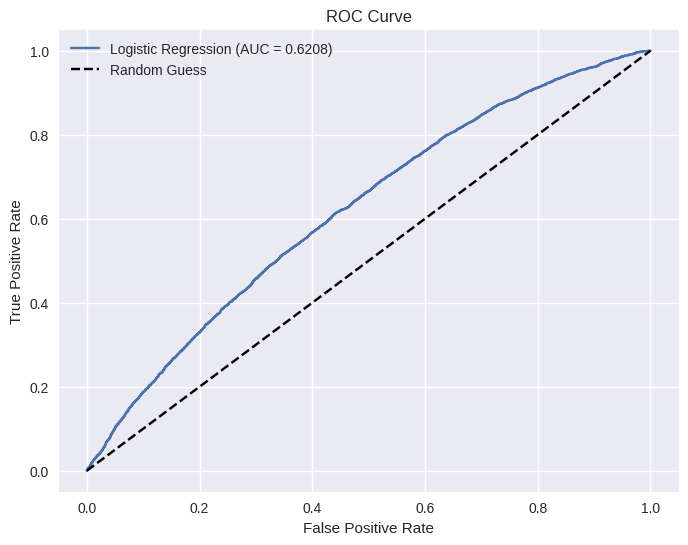

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

# Calculate ROC curve values: FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calculate AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", auc_score)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
TN, FP = confusion_matrix(y_test, y_pred)[0]
FN, TP = confusion_matrix(y_test, y_pred)[1]
profit = TP * 5.5 + (FP + TP) * -1
print(f"Profit: {profit}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Model Tuning

In [ ]:
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    matrix = confusion_matrix(y_test, y_pred)
    accuracyScore = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = (TP * 5.5 + (FP + TP) * -1) / len(y_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Average Profit: {profit}")


    y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

    # Calculate ROC curve values: FPR, TPR, and threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # Calculate AUC (Area Under the Curve)
    auc_score = roc_auc_score(y_test, y_proba)
    print("AUC-ROC Score:", auc_score)
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return accuracyScore, auc_score, f1, profit

### Class Resampling

Accuracy: 0.6631216034593583
Confusion Matrix:
 [[4077 2507]
 [3258 7271]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.62      0.59      6584
         1.0       0.74      0.69      0.72     10529

    accuracy                           0.66     17113
   macro avg       0.65      0.65      0.65     17113
weighted avg       0.67      0.66      0.67     17113

Profit: 30212.5
AUC-ROC Score: 0.7174159213337414
F1 Score: 0.7161077460974048


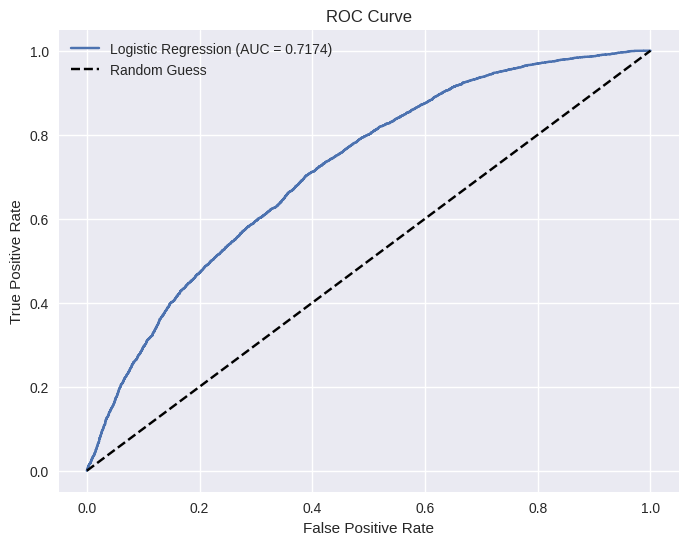

(0.6631216034593583, 0.7174159213337414, 0.7161077460974048, 30212.5)

In [ ]:
# Apply SMOTE and Edited Nearest Neighbors (SMOTEENN)
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']
smoteenn = SMOTEENN()
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

log_reg(X_resampled, y_resampled)

### PCA

In [ ]:
# Set info limit to 95%
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_resampled)

print("Number of components:", pca.n_components_)

Number of components: 79


Accuracy: 0.6496815286624203
Confusion Matrix:
 [[3968 2616]
 [3379 7150]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.60      0.57      6584
         1.0       0.73      0.68      0.70     10529

    accuracy                           0.65     17113
   macro avg       0.64      0.64      0.64     17113
weighted avg       0.66      0.65      0.65     17113

Average Profit: 1.7272833518377841
AUC-ROC Score: 0.6972288796308338
F1 Score: 0.7046070460704607


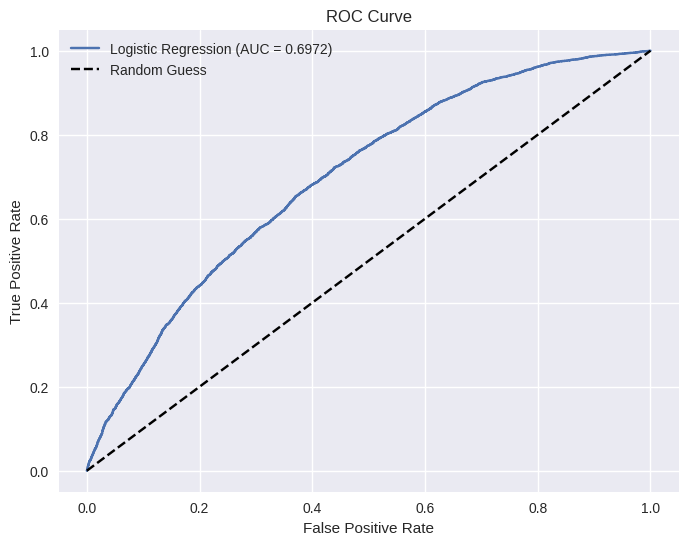

(0.6496815286624203,
 0.6972288796308338,
 0.7046070460704607,
 1.7272833518377841)

In [ ]:
X = X_pca
y = y_resampled

log_reg(X, y)

### Forward Selection

In [ ]:
# Step 2: Split the dataset into training and testing sets
X = pd.DataFrame(X_pca)
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

# Step 3: Initialize logistic regression model
model = LogisticRegression(solver='liblinear')

# Step 4: Forward Selection based on Precision of 1s
selected_features = []
best_precision = 0
remaining_features = list(range(X_train.shape[1]))

# Iterate over the remaining features
while remaining_features:
    precision_scores = []

    # Try adding each remaining feature and evaluate model precision on 1s
    for feature in remaining_features:
        features_to_test = selected_features + [feature]
        # Use .iloc for integer-based indexing
        X_train_subset = X_train.iloc[:, features_to_test]

        # Fit the model and calculate precision on 1s (positive class)
        model.fit(X_train_subset, y_train)
        # Use .iloc for integer-based indexing
        y_pred = model.predict(X_test.iloc[:, features_to_test])
        precision = precision_score(y_test, y_pred, pos_label=1)

        precision_scores.append((precision, feature))

    # Select the feature that improves precision the most
    precision_scores.sort(reverse=True, key=lambda x: x[0])  # Sort by precision

    best_precision_score, best_feature = precision_scores[0]

    if best_precision_score > best_precision:
        selected_features.append(best_feature)  # Add the best feature to the selected set
        best_precision = best_precision_score  # Update the best precision
        remaining_features.remove(best_feature)  # Remove the selected feature from remaining features
        print(f"Selected Features: {selected_features}")
        print(f"Best Precision: {best_precision}")
    else:
        break  # No improvement, stop the selection process

# Step 5: Final model evaluation
# Use .iloc for integer-based indexing
X_train_selected = X_train.iloc[:, selected_features]
# Use .iloc for integer-based indexing
X_test_selected = X_test.iloc[:, selected_features]

model.fit(X_train_selected, y_train)
y_pred_final = model.predict(X_test_selected)

# Calculate final precision on 1s (positive class)
final_precision = precision_score(y_test, y_pred_final, pos_label=1)
print(f'Final precision on 1s: {final_precision}')
print(f'Selected Features: {selected_features}')

Selected Features: [6]
Best Precision: 0.6474947311170032
Selected Features: [6, 5]
Best Precision: 0.6573798824749395
Selected Features: [6, 5, 3]
Best Precision: 0.662138132157337
Selected Features: [6, 5, 3, 21]
Best Precision: 0.6706974735478298
Selected Features: [6, 5, 3, 21, 0]
Best Precision: 0.6777646537723313
Selected Features: [6, 5, 3, 21, 0, 11]
Best Precision: 0.6808895589898228
Selected Features: [6, 5, 3, 21, 0, 11, 24]
Best Precision: 0.6831479506323328
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10]
Best Precision: 0.68538983309199
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10, 4]
Best Precision: 0.6877549449703687
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10, 4, 77]
Best Precision: 0.6901202219482121
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10, 4, 77, 73]
Best Precision: 0.6907494415774474
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10, 4, 77, 73, 52]
Best Precision: 0.6911277268172358
Selected Features: [6, 5, 3, 21, 0, 11, 24, 10, 4, 77, 73, 52, 56]
Best Prec

### Lasso

In [ ]:
from sklearn.metrics import mean_squared_error
X = X_pca[:, selected_features]
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

# 6. Apply Lasso: Lasso regression on PCA-transformed data
lasso = Lasso(alpha=0.1)  # Adjust alpha as needed for regularization strength
lasso.fit(X_train, y_train)

# 7. Evaluate the model
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also check the coefficients
print("Lasso Coefficients:", lasso.coef_)

Mean Squared Error: 0.23154630450566877
Lasso Coefficients: [ 0.02175644 -0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.        ]


### Threshold

Accuracy: 0.6431952316952024
Confusion Matrix:
 [[3572 3012]
 [3094 7435]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.54      0.54      6584
         1.0       0.71      0.71      0.71     10529

    accuracy                           0.64     17113
   macro avg       0.62      0.62      0.62     17113
weighted avg       0.64      0.64      0.64     17113



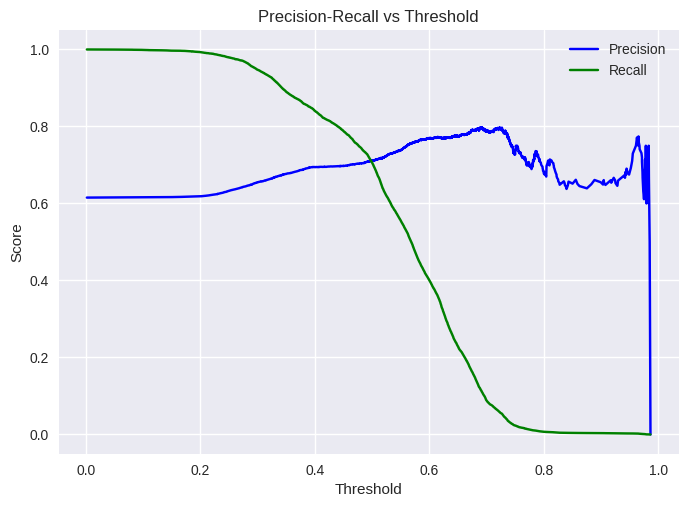

In [ ]:
X = X_pca[:, selected_features]
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

Optimal Threshold: 0.04
Maximum Profit: $40803.00


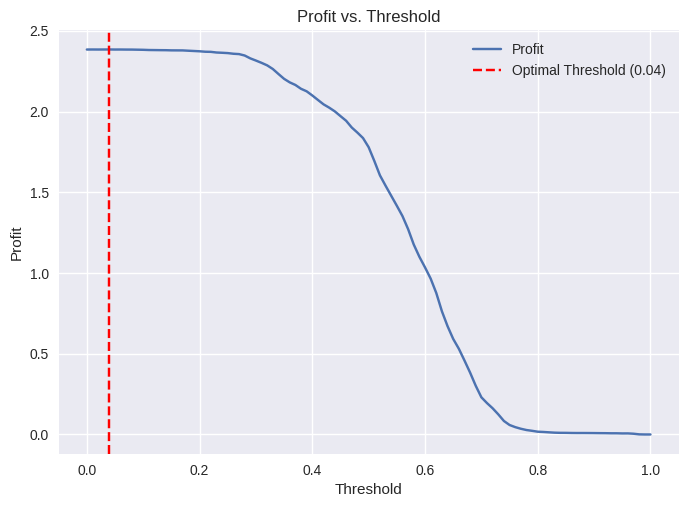

In [ ]:
# Threshold optimization for profit
thresholds = np.arange(0, 1.01, 0.01)  # Thresholds from 0 to 1 in increments of 0.01
profits = []
average_profit = []
X = X_pca[:, selected_features]
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate profit
    profit = (5.5 * tp) - ((tp + fp) * 1)
    profits.append(profit)
    average_profit.append(profit / (len(y_test)))

# Find the optimal threshold
optimal_index = np.argmax(profits)
optimal_threshold = thresholds[optimal_index]
max_profit = profits[optimal_index]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum Profit: ${max_profit:.2f}")

# Plotting the profit vs. threshold
plt.plot(thresholds, average_profit, label='Profit')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold')
plt.legend(loc='best')
plt.show()

Threshold: 0.00 | TP: 10529, FP: 6584, FN: 0, TN: 0
Accuracy: 0.6153 | FPR: 1.0000 | FNR: 0.0000 | Advertising Revenue (Cents Per Person): 0.00
Threshold: 0.01 | TP: 10529, FP: 6579, FN: 0, TN: 5
Accuracy: 0.6156 | FPR: 0.9992 | FNR: 0.0000 | Advertising Revenue (Cents Per Person): 238.39
Threshold: 0.02 | TP: 10528, FP: 6577, FN: 1, TN: 7
Accuracy: 0.6156 | FPR: 0.9989 | FNR: 0.0001 | Advertising Revenue (Cents Per Person): 238.42
Threshold: 0.03 | TP: 10527, FP: 6574, FN: 2, TN: 10
Accuracy: 0.6157 | FPR: 0.9985 | FNR: 0.0002 | Advertising Revenue (Cents Per Person): 238.41
Threshold: 0.04 | TP: 10524, FP: 6567, FN: 5, TN: 17
Accuracy: 0.6160 | FPR: 0.9974 | FNR: 0.0005 | Advertising Revenue (Cents Per Person): 238.40
Threshold: 0.05 | TP: 10521, FP: 6560, FN: 8, TN: 24
Accuracy: 0.6162 | FPR: 0.9964 | FNR: 0.0008 | Advertising Revenue (Cents Per Person): 238.36
Threshold: 0.06 | TP: 10520, FP: 6555, FN: 9, TN: 29
Accuracy: 0.6164 | FPR: 0.9956 | FNR: 0.0009 | Advertising Revenue (Ce

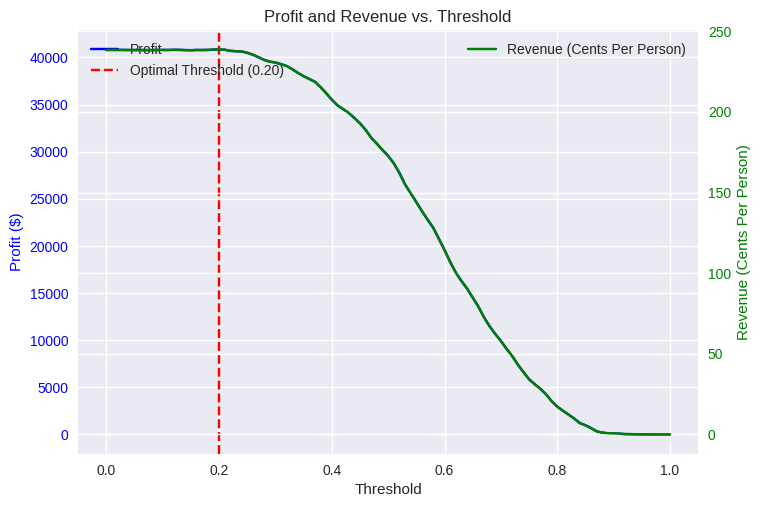

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Set threshold range
thresholds = np.arange(0, 1.01, 0.01)  # Thresholds from 0 to 1 in increments of 0.01
profits = []
revenues_per_person = []

X = X_pca
y = y_resampled

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

# Fit the logistic regression model
model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate profits and revenue per person for each threshold
for threshold in thresholds:
    # Apply the threshold to the predicted probabilities
    y_pred = (y_proba >= threshold).astype(int)

    # Get confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Avoid division by zero
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # Avoid division by zero

    # Debugging: Print confusion matrix values
    print(f"Threshold: {threshold:.2f} | TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"Accuracy: {accuracy:.4f} | FPR: {fpr:.4f} | FNR: {fnr:.4f} | Advertising Revenue (Cents Per Person): {revenue_cents_per_person:.2f}")

    # Calculate total profit
    profit = (5.5 * tp) - (1 * (tp + fp))  # Your profit formula

    # Calculate revenue per person (in cents)
    total_population = len(y_test)
    revenue_cents_per_person = (profit / total_population) * 100

    profits.append(profit)
    revenues_per_person.append(revenue_cents_per_person)

# Find the optimal threshold based on profit
optimal_index = np.argmax(profits)
optimal_threshold = thresholds[optimal_index]
max_profit = profits[optimal_index]
optimal_revenue = revenues_per_person[optimal_index]

# Print the optimal threshold and revenue
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum Profit: ${max_profit:.2f}")
print(f"Revenue (Cents Per Person) at Optimal Threshold: {optimal_revenue:.2f} cents")

# Plotting profit and revenue vs. threshold
fig, ax1 = plt.subplots()

# Plot profit
ax1.plot(thresholds, profits, label='Profit', color='b')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Profit ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot revenue (cents per person)
ax2 = ax1.twinx()
ax2.plot(thresholds, revenues_per_person, label='Revenue (Cents Per Person)', color='g')
ax2.set_ylabel('Revenue (Cents Per Person)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a vertical line for the optimal threshold
ax1.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')

# Title and legends
plt.title('Profit and Revenue vs. Threshold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [ ]:
optimal_threshold = 0.45
model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)
# Predict probabilities for the test set
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))


Confusion Matrix with Optimal Threshold:
 [[3377 3138]
 [2638 8459]]
Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

         0.0       0.56      0.52      0.54      6515
         1.0       0.73      0.76      0.75     11097

    accuracy                           0.67     17612
   macro avg       0.65      0.64      0.64     17612
weighted avg       0.67      0.67      0.67     17612



### Final Model

In [ ]:
model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(test_data_standardized)
list_predictions =y_pred.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 

# Modelling Method 2 - Random Forests

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=42)

## Random Forest

## Fitting Original Model
The whole training dataset is fitted with all the columns in this section

Accuracy: 0.7784866031995289


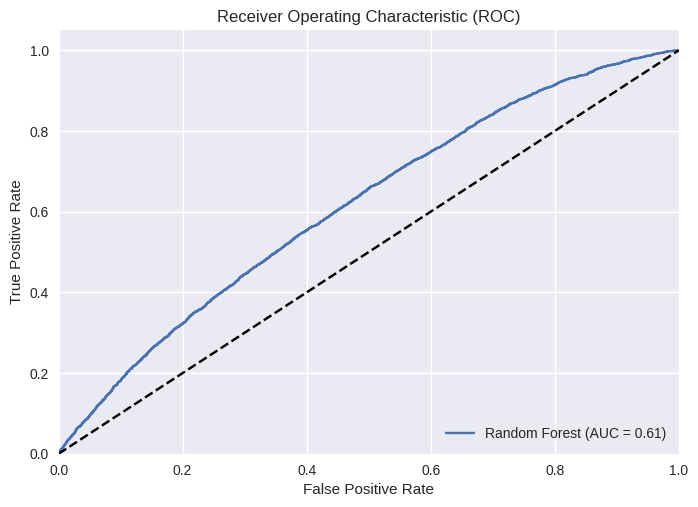

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a new RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.2215133968004711

## Prediction Analysis

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


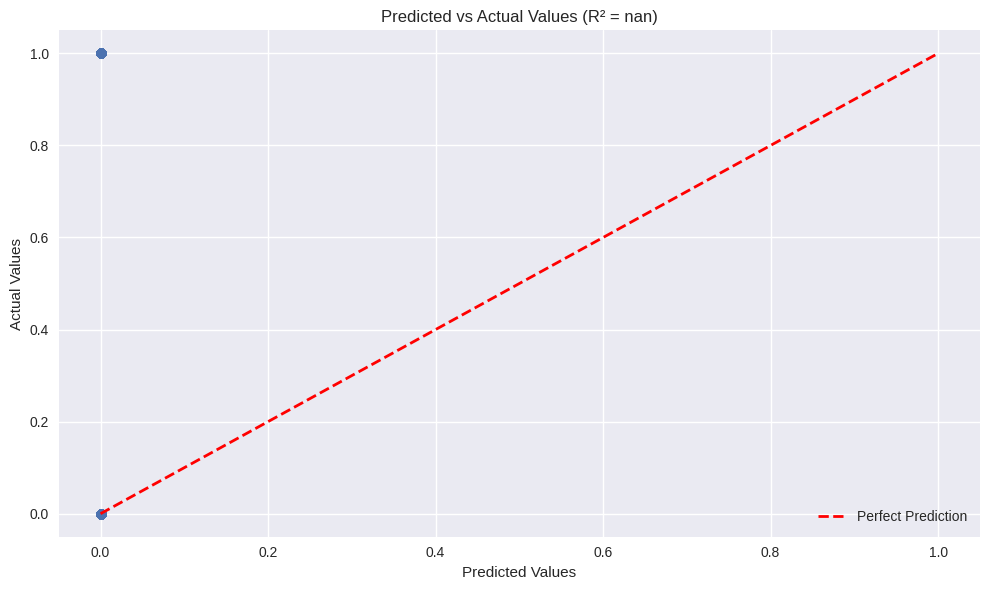

In [53]:
def plot_prediction_analysis(y_test, y_pred):
    # Calculate R-squared
    r2 = np.corrcoef(y_test, y_pred)[0,1]**2

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create regression plot
    sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5})

    # Add perfect prediction line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')

    # Add labels and title
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.3f})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use it like this:
plot_prediction_analysis(y_test, y_pred)

In [54]:
insurance_rf = RandomForestRegressor(max_features=6, random_state=42, n_estimators=100)
insurance_rf.fit(X_train, y_train)

y_pred = insurance_rf.predict(X_test)

mean_squared_error(y_test, y_pred)

0.1758607040750612

## Model Tuning

### Important Features

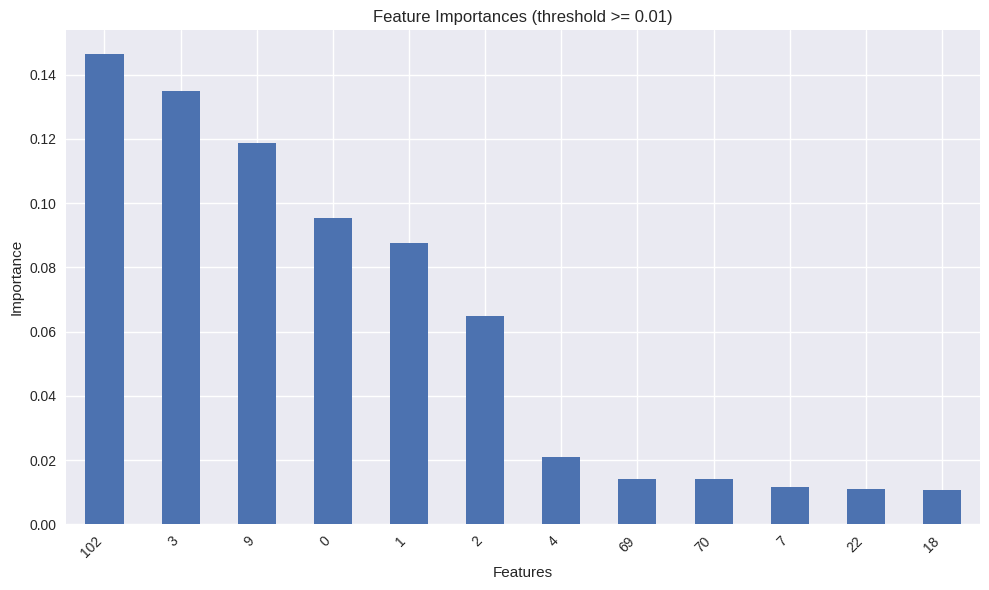


Feature Importances:
102: 0.1465
3: 0.1349
9: 0.1186
0: 0.0955
1: 0.0877
2: 0.0648
4: 0.0210
69: 0.0142
70: 0.0142
7: 0.0115
22: 0.0112
18: 0.0108


In [55]:
def plot_feature_importances(model, feature_names, x_tick_rotation=45, threshold=0.01):
    # Get feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names)

    # Filter features above threshold
    importances = importances[importances >= threshold]

    # Sort in descending order
    importances = importances.sort_values(ascending=False)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    importances.plot(kind='bar')

    # Add labels and title
    plt.title(f'Feature Importances (threshold >= {threshold})')
    plt.xlabel('Features')
    plt.ylabel('Importance')

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation, ha='right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()

    # Print sorted importances
    print("\nFeature Importances:")
    for name, importance in importances.items():
        print(f"{name}: {importance:.4f}")

# Use it like this:
plot_feature_importances(insurance_rf, X.columns, x_tick_rotation=45, threshold=0.01)

In [56]:
# Get important features (e.g., those with importance > threshold)
threshold = 0.01  # adjust this based on your needs
important_features = pd.Series(insurance_rf.feature_importances_, index=X.columns)
important_features = important_features[important_features > threshold].index

# Create new dataset with only important features
X_important = X[important_features]

# # Train new model with important features only
# model_important = rfi(random_state=42)  # or your chosen model
# model_important.fit(X_important, y)

### Fitting Feature Selected Model

Accuracy: 0.7784866031995289


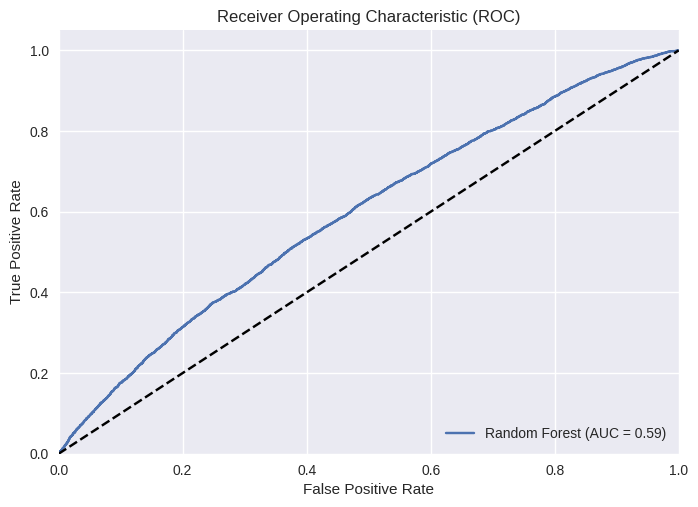

In [57]:
#rom sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Initialize a new RandomForestClassifier
rfi_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rfi_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rfi_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rfi_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Cross-Validation

In [58]:
from sklearn.model_selection import cross_val_score

# Original model performance
scores_original = cross_val_score(rf_model, X, y, cv=5)

# New model performance with important features only
scores_important = cross_val_score(rfi_model, X_important, y, cv=5)

print("Original model CV scores:", scores_original.mean(), "±", scores_original.std())
print("Important features model CV scores:", scores_important.mean(), "±", scores_important.std())

Original model CV scores: 0.7812150358229463 ± 2.404053138466841e-05
Important features model CV scores: 0.7812150358229463 ± 2.404053138466841e-05


In [59]:
# if len(important_features) >= 2:
#     top_2_features = important_features[:2]
#     X_important[f'{top_2_features[0]}_x_{top_2_features[1]}'] = (
#         X_important[top_2_features[0]] * X_important[top_2_features[1]]
#     )

### Hyper-Parameter Tuning

In [60]:
# prompt: use RandomizedSearchCV for hyperparamter tuning

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rfi_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best model for prediction
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best score: 0.7818971443838677
Accuracy: 0.7784866031995289


### Adjusting Threshold for Revenue Maximizing

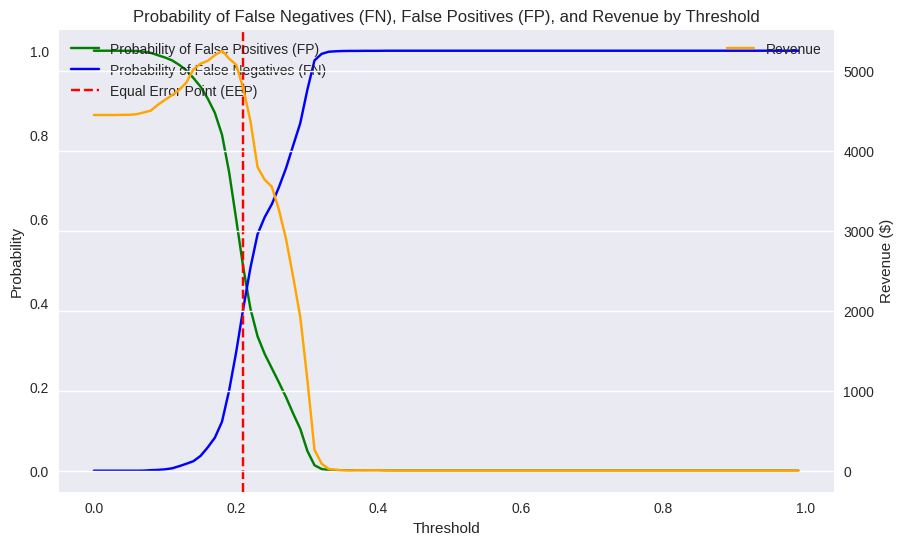

Equal Error Point (EEP) Threshold: 0.21


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict probabilities for the positive class
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
false_positive_rates = []
false_negative_rates = []
revenues = []

# Calculate FPR, FNR, and revenue for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test[:len(y_pred)], y_pred).ravel()

    # Calculate false positive rate and false negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Append FPR and FNR to lists
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)

    # Calculate revenue: (5.5 * True Positives) - (1 * Predicted Positives)
    revenue = (5.5 * tp) - (1 * (tp + fp))
    revenues.append(revenue)

# Plotting FPR and FNR against thresholds
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot false positive and false negative rates
ax1.plot(thresholds, false_positive_rates, label="Probability of False Positives (FP)", color="green")
ax1.plot(thresholds, false_negative_rates, label="Probability of False Negatives (FN)", color="blue")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Probability")
ax1.set_title("Probability of False Negatives (FN), False Positives (FP), and Revenue by Threshold")
ax1.grid()
ax1.legend(loc="upper left")

# Plot revenue on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, revenues, label="Revenue", color="orange")
ax2.set_ylabel("Revenue ($)")
ax2.legend(loc="upper right")

# Mark the Equal Error Point (EEP) where FP and FN rates intersect
equal_error_point = thresholds[np.argmin(np.abs(np.array(false_positive_rates) - np.array(false_negative_rates)))]
ax1.axvline(equal_error_point, color="red", linestyle="--", label="Equal Error Point (EEP)")
ax1.legend(loc="upper left")

plt.show()

print(f"Equal Error Point (EEP) Threshold: {equal_error_point}")


### Predicting with Final Model

This model has an advertising revenue of 12 on the leaderboard

In [62]:

# Align test data columns with training data
test_data_standardized = test_data_standardized.reindex(columns=X.columns, fill_value=0)

# Get probabilities for the positive class (ISBOUND=1)
probabilities = rf_model.predict_proba(test_data_standardized)[:, 1]

# Apply the EEP threshold
threshold = 0.21
predictions = (probabilities >= threshold).astype(int)

# Convert predictions to a list
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]

# Output predictions
print("Predictions:", rounded_list_predictions)
print("Number of predictions:", len(rounded_list_predictions))


Predictions: [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,